In [2]:
import sxdes
import galsim
import numpy as np
import proplot as pplt

In [40]:
def _run_det(psf, rng):
    nse = 1e-4
    dim = 73
    im = psf.drawImage(nx=dim, ny=dim).array
    im += rng.normal(size=im.shape, scale=nse)
    cat, _ = sxdes.run_sep(im, nse)
    return cat, im, nse
    

In [41]:
import tqdm
for i in tqdm.trange(100):
    rng = np.random.RandomState()
    psf = galsim.Moffat(beta=1.5, fwhm=0.9)
    cat, im, nse = _run_det(psf, rng)
    if len(cat) > 1:
        break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.90it/s]


<a list of 1 Line2D objects>

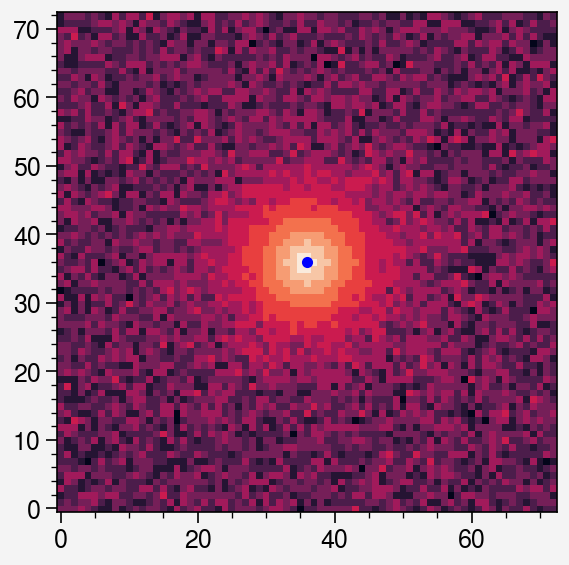

In [42]:
fig, axs = pplt.subplots()
axs.pcolormesh(np.arcsinh(im/nse), cmap="rocket")
axs.plot(cat["x"], cat["y"], '.b')

In [3]:
import meds

In [4]:
m = meds.MEDS("DES0000+0209_r5763p01_r_pizza-cutter-slices.fits.fz")

In [5]:
def _run_det(psf, rng, m):
    dim = 101
    while True:
        ind = rng.randint(0, m.size)
        if m["ncutout"][ind] == 0:
            continue
        nse = m.get_cutout(ind, 0, type="noise")
        bmask = m.get_cutout(ind, 0, type="bmask")
        xloc = rng.randint(0, nse.shape[1]-dim)
        yloc = rng.randint(0, nse.shape[0]-dim)
        if np.all(bmask[yloc:yloc+dim, xloc:xloc+dim] == 0):
            break
    im = psf.drawImage(nx=dim, ny=dim).array * 2e5
    im += nse[yloc:yloc+dim, xloc:xloc+dim]
    cat, _ = sxdes.run_sep(im, np.std(nse))
    return cat, im, np.std(nse)
    

In [74]:
import tqdm
cats = []
for i in tqdm.trange(8000):
    rng = np.random.RandomState()
    psf = galsim.Moffat(beta=1.5, fwhm=1.2)
    cat, im, nse = _run_det(psf, rng, m)
    if len(cat) > 1:
        cats.append(cat)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [15:57<00:00,  8.35it/s]


In [75]:
cats = np.concatenate(cats, axis=0)

<a list of 1 Line2D objects>

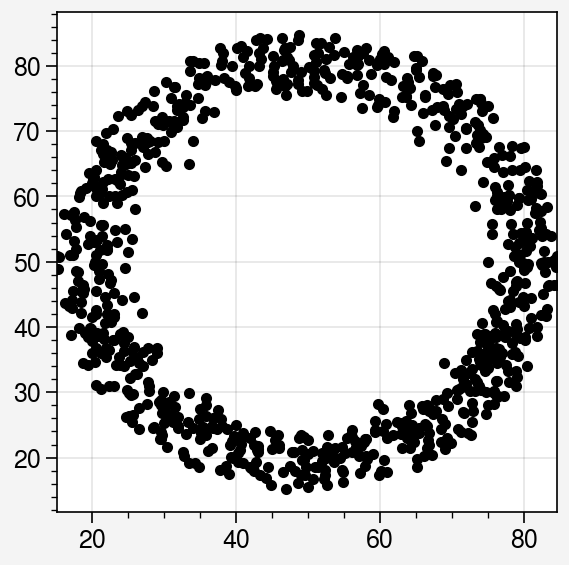

In [76]:
r = np.sqrt((np.abs(cats["x"]-50))**2 + (np.abs(cats["y"]-50))**2)
msk = (r > 5) & (r < 35)

fig, axs = pplt.subplots()
# axs.hexbin(cats["x"][msk], cats["y"][msk], norm='log', cmap="rocket_r")
axs.plot(cats["x"][msk], cats["y"][msk], 'k.')

In [81]:
a = np.arctan2(cats["y"][msk]-50, cats["x"][msk]-50)/np.pi*180 + 180

(array([52., 51., 55., 58., 50., 59., 70., 60., 51., 38., 49., 53., 56.,
        45., 57., 51.]),
 array([  0.76493099,  23.21674092,  45.66855085,  68.12036078,
         90.57217071, 113.02398064, 135.47579057, 157.92760049,
        180.37941042, 202.83122035, 225.28303028, 247.73484021,
        270.18665014, 292.63846007, 315.09027   , 337.54207993,
        359.99388986]),
 <BarContainer object of 16 artists>)

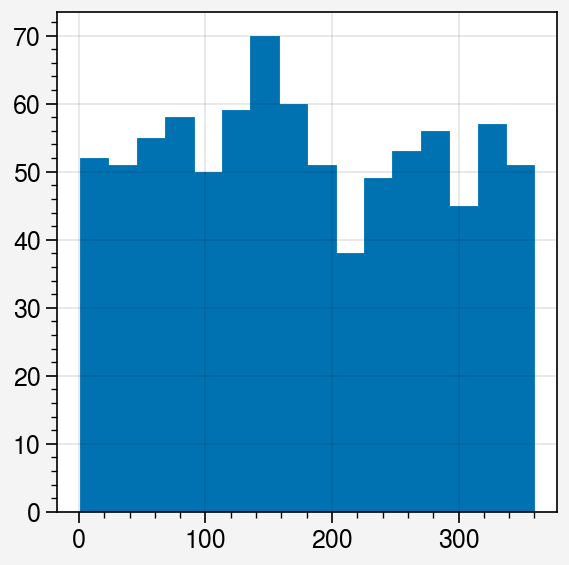

In [82]:
fig, axs = pplt.subplots()
axs.hist(a, bins=16)